# [Flight delays](https://www.kaggle.com/c/flight-delays-spring-2018/overview)
Kaggle InClass competiton by [mlcourse.ai](mlcourse.ai). The task is to predict whether a flight will be delayed for more than 15 minutes

## Initialization

In [1]:
import numpy as np
import pandas as pd
import statsmodels.stats.weightstats as wsts
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['patch.force_edgecolor'] = True

# pip install watermark
%load_ext watermark
%watermark -v -m -r -b -g -p numpy,pandas,sklearn,matplotlib,statsmodels,xgboost,catboost

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
matplotlib 3.0.2
statsmodels 0.9.0
xgboost 0.81
catboost 0.11.2

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 10f8b993ac90c4de1583165027d9b5120fc1796e
Git repo   : 
Git branch : master


## Data import and initial research

### IMPORT

In [2]:
!ls ../raw_competition_data/

flight_delays_test.csv.zip  get_data.txt
flight_delays_train.csv.zip sample_submission.csv.zip


In [3]:
train = pd.read_csv('../raw_competition_data/flight_delays_train.csv.zip', 
                    engine='c')
test = pd.read_csv('../raw_competition_data/flight_delays_test.csv.zip', 
                   engine='c')

In [4]:
_addr = '../raw_competition_data/sample_submission.csv.zip'
sample_submission = pd.read_csv(_addr, engine='c')
sample_submission.head(1)

,id,dep_delayed_15min
0,0,0.081


Features:

- **Month, DayofMonth, DayOfWeek**
- **DepTime** – departure time
- **UniqueCarrier** – code of a company-career
- **Origin** – flight origin
- **Dest** – flight destination
- **Distance** - distance between Origin and Dest airports
- **dep_delayed_15min** – target

In [5]:
train['dep_delayed_15min'] = train['dep_delayed_15min'].map({'N': 0, 'Y': 1})
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1


In [6]:
# Table to picture the origin_dest delay dependencies. (It will happen in 
# the "Research" section)
origin_dest_table = train.pivot_table(index='Origin', columns='Dest', 
                                      values='dep_delayed_15min', 
                                      aggfunc='sum', fill_value=0)

Some feature engineering

In [7]:
num_cols = ['Distance']
datetime_cols = ['Month','DayofMonth','DayOfWeek']
cat_cols = ['UniqueCarrier', 'Origin', 'Dest']
train[num_cols] = train[num_cols].astype('float')

# Remove `c-` from the date cols
train[datetime_cols] = train[datetime_cols].applymap(lambda x: x[2:])
train[datetime_cols] = train[datetime_cols].astype('int')

# Extract Hour and Minute of departure from the `DepTime`
train['Hour'] = train['DepTime'].apply(lambda x: x // 100)
train['Hour'] = train['Hour'].astype('int')
train['Minute'] = train['DepTime'].apply(lambda x: x % 100)
train['Minute'] = train['Minute'].astype('int')
train.drop('DepTime', axis=1, inplace=True)

# During visual analysis has been founded that six objects has DepTime hour 
# equal to 25. I decided to drop such objects
train = train[train.Hour != 25]

train['IsWeekend'] = train['DayOfWeek'].isin([6,7]).astype('int')

In [8]:
train[train.Hour ==25]

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Hour,Minute,IsWeekend


In [9]:
train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Hour,Minute,IsWeekend
0,8,21,7,AA,ATL,DFW,732.0,0,19,34,1
1,4,20,3,US,PIT,MCO,834.0,0,15,48,0
2,9,2,5,XE,RDU,CLE,416.0,0,14,22,0
3,11,25,6,OO,DEN,MEM,872.0,0,10,15,1
4,10,7,6,WN,MDW,OMA,423.0,1,18,28,1


In [10]:
target = train[['dep_delayed_15min']]
train.drop('dep_delayed_15min', axis=1, inplace=True)

In [11]:
test.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
Month            100000 non-null object
DayofMonth       100000 non-null object
DayOfWeek        100000 non-null object
DepTime          100000 non-null int64
UniqueCarrier    100000 non-null object
Origin           100000 non-null object
Dest             100000 non-null object
Distance         100000 non-null int64
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [13]:
test[num_cols] = test[num_cols].astype('float')
test[datetime_cols] = test[datetime_cols].applymap(lambda x: x[2:])
test[datetime_cols] = test[datetime_cols].astype('int')

test['Hour'] = test['DepTime'].apply(lambda x: x // 100)
test['Hour'] = test['Hour'].astype('int')
test['Minute'] = test['DepTime'].apply(lambda x: x % 100)
test['Minute'] = test['Minute'].astype('int')
test.drop('DepTime', axis=1, inplace=True)

test['IsWeekend'] = test['DayOfWeek'].isin([6,7]).astype('int')

In [14]:
test.head(3)

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Hour,Minute,IsWeekend
0,7,25,3,YV,MRY,PHX,598.0,6,15,0
1,4,17,2,WN,LAS,HOU,1235.0,7,39,0
2,12,2,7,MQ,GSP,ORD,577.0,6,51,1


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
Month            100000 non-null int64
DayofMonth       100000 non-null int64
DayOfWeek        100000 non-null int64
UniqueCarrier    100000 non-null object
Origin           100000 non-null object
Dest             100000 non-null object
Distance         100000 non-null float64
Hour             100000 non-null int64
Minute           100000 non-null int64
IsWeekend        100000 non-null int64
dtypes: float64(1), int64(6), object(3)
memory usage: 7.6+ MB


In [16]:
datetime_cols.append('Hour')
datetime_cols.append('Minute')

### RESEARCH

#### Class balance

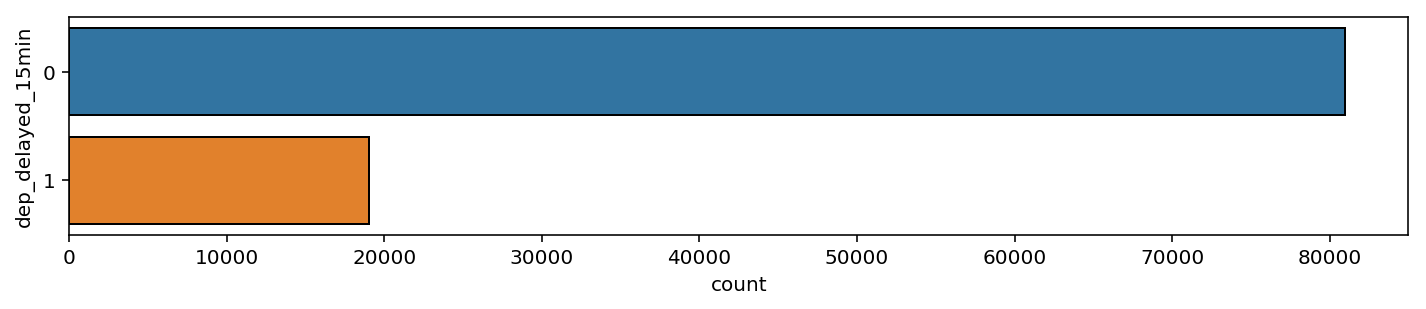

In [17]:
plt.figure(figsize=(12,2))
sns.countplot(y=target.dep_delayed_15min);

Our dataset is unbalanced, hense we should to take some action to overhead this problem in the case of training decision trees or related models.

#### Datetime features distributions

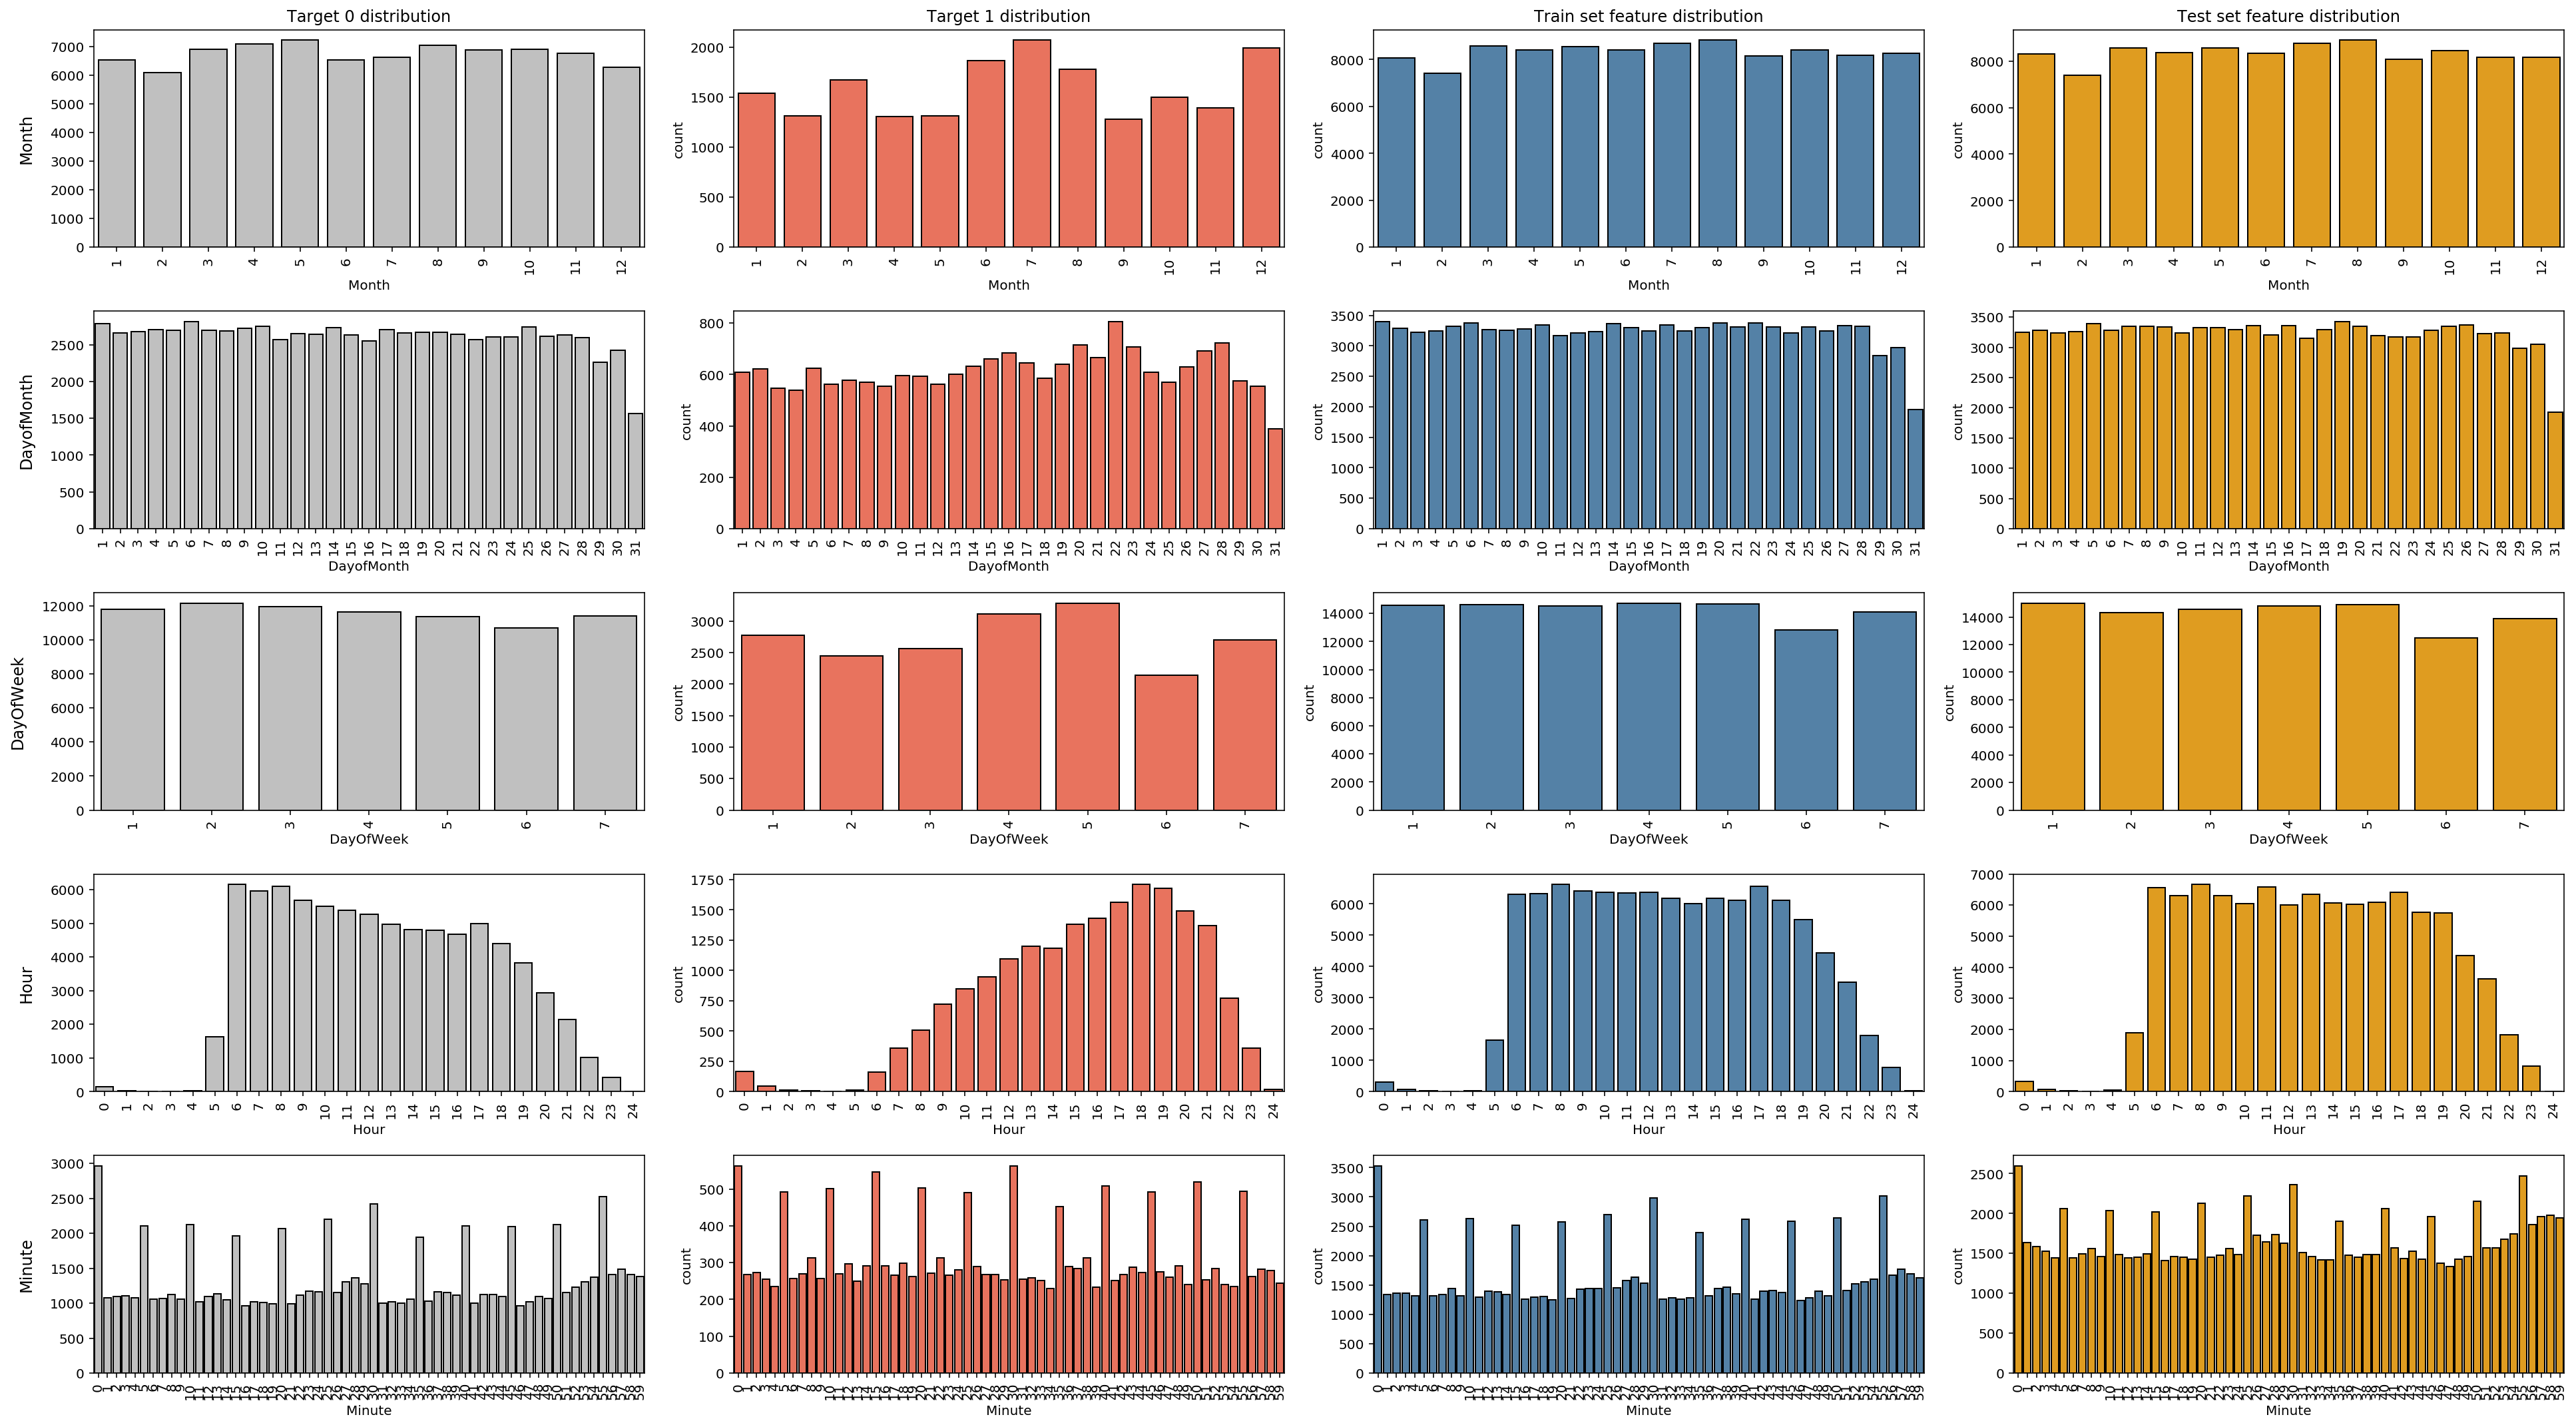

In [18]:
fig, axes = plt.subplots(5, 4, figsize=(27, 3*5))

for ax, col in zip(axes, datetime_cols):
    _plot_data = train
    s = sns.countplot(data=train[target.dep_delayed_15min==0], 
                  x=col, ax=ax[0], color='silver')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    s = sns.countplot(data=train[target.dep_delayed_15min==1], 
                  x=col, ax=ax[1], color='tomato')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    s = sns.countplot(data=train, x=col, ax=ax[2], color='steelblue')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    s = sns.countplot(data=test, x=col, ax=ax[3], color='orange')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)

    
# Column row names
cols = ['Target 0 distribution', 
        'Target 1 distribution',
        'Train set feature distribution',
        'Test set feature distribution']
rows = datetime_cols
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, labelpad=12, size='large')
    
fig.tight_layout()

We see, that in the train and in  the test sets data is distrubuted in a similar way, hence we can use this features o predict target on the test data. In addition, We can notice, that target data in the every feature has a bit different distribution, what is a good news to us – it means, that target data can be distinguished in some way in all data by these features.

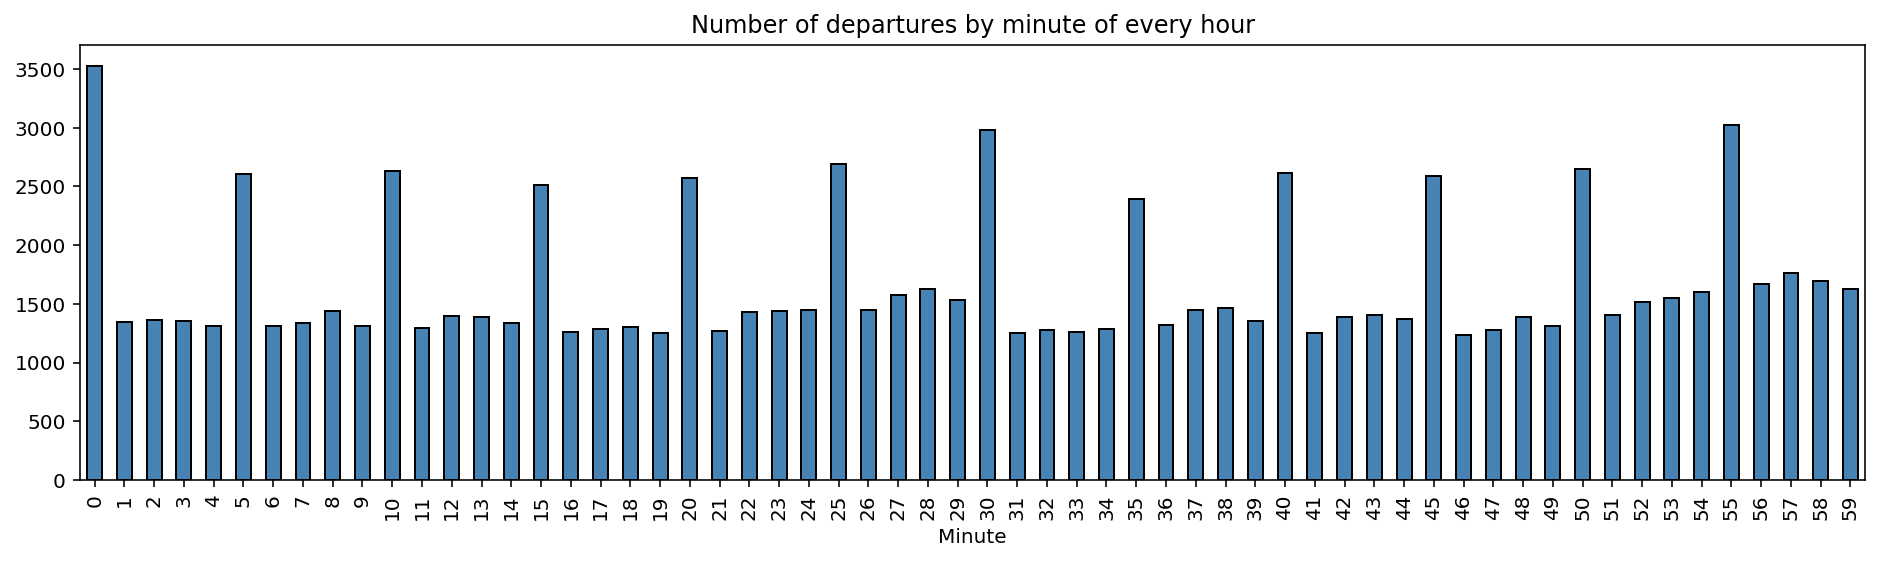

In [19]:
plt.figure(figsize=(16,4))
train.groupby('Minute').size().plot(kind='bar', color='steelblue')
plt.title('Number of departures by minute of every hour');

Here is some

#### Unique carrier distribution between train and dataset

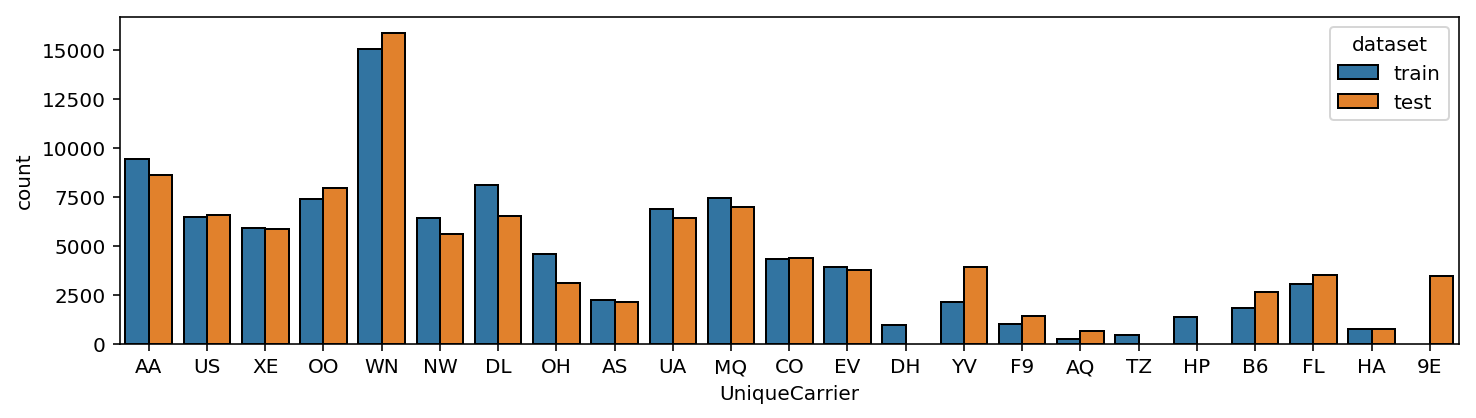

In [20]:
train_carrier = train[['UniqueCarrier']].copy()
train_carrier['set'] = 'train'
train_carrier['target'] = target['dep_delayed_15min'].values
test_carrier = test[['UniqueCarrier']].copy()
test_carrier['set'] = 'test'
unique_carrier = pd.concat([train_carrier[['UniqueCarrier', 'set']], 
                            test_carrier])

plt.figure(figsize=(12,3))
s = sns.countplot(data=unique_carrier, x='UniqueCarrier', hue='set')
s.legend(title='dataset', loc=1);

#### Target distribution on UniqueCarrier feature

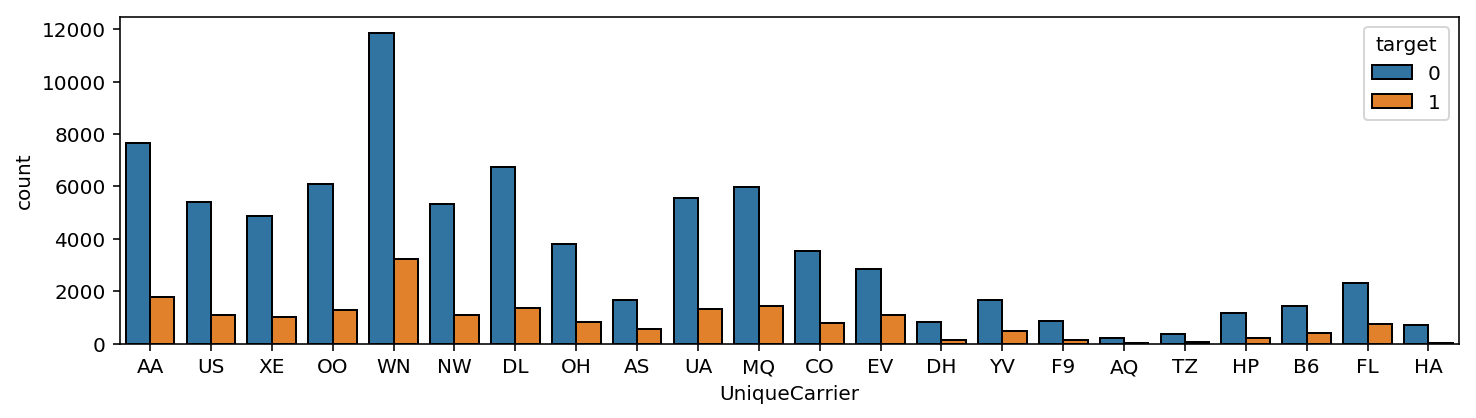

In [21]:
plt.figure(figsize=(12,3))
sns.countplot(data=train_carrier, x='UniqueCarrier', hue='target');

#### Origin -> Destination delay
In this figure, we cannot specify exact flights that are usually delayed, but we see that delays are not uniformly distributed, and, moreover, there are several departure and destination airports with constant flight delays.

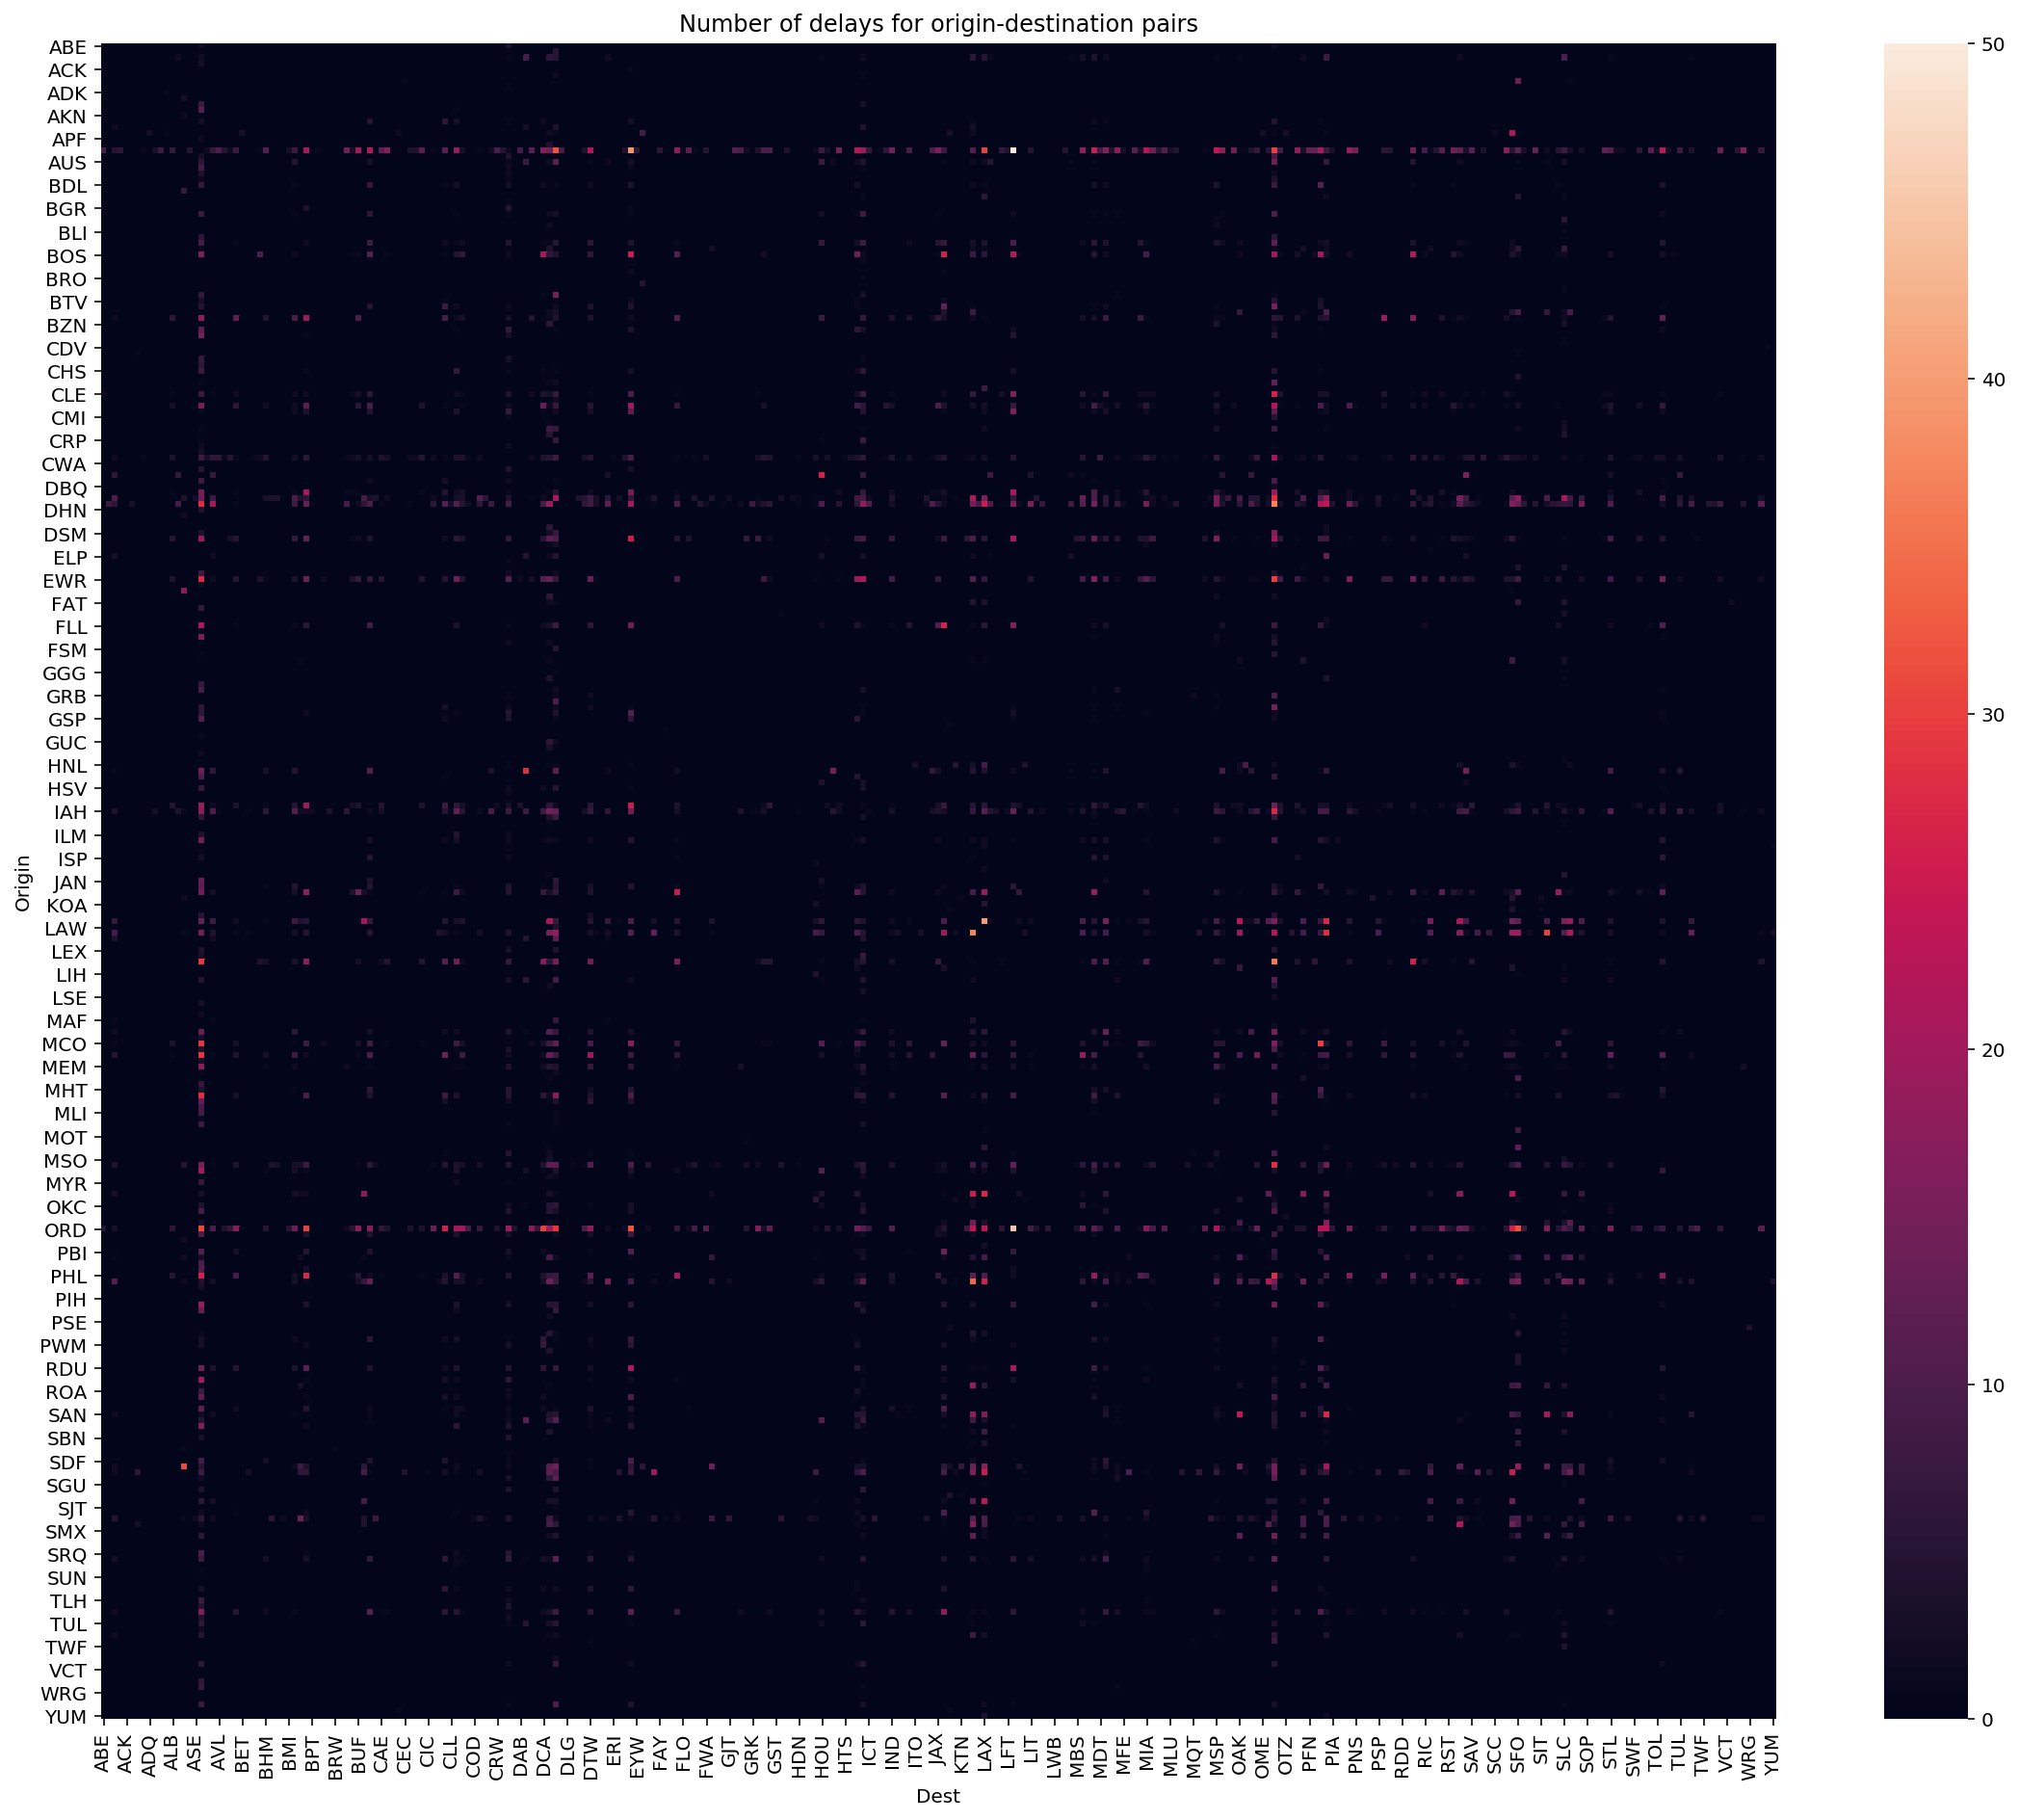

In [22]:
plt.figure(figsize=(20,16))
sns.heatmap(origin_dest_table, square=True)
plt.title('Number of delays for origin-destination pairs');

### EXPORT TRAIN/TEST DATASET AND TARGET

In [23]:
train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Hour,Minute,IsWeekend
0,8,21,7,AA,ATL,DFW,732.0,19,34,1
1,4,20,3,US,PIT,MCO,834.0,15,48,0
2,9,2,5,XE,RDU,CLE,416.0,14,22,0
3,11,25,6,OO,DEN,MEM,872.0,10,15,1
4,10,7,6,WN,MDW,OMA,423.0,18,28,1


In [24]:
test.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,Hour,Minute,IsWeekend
0,7,25,3,YV,MRY,PHX,598.0,6,15,0
1,4,17,2,WN,LAS,HOU,1235.0,7,39,0
2,12,2,7,MQ,GSP,ORD,577.0,6,51,1
3,3,25,7,WN,BWI,MHT,377.0,16,14,1
4,6,6,3,UA,ORD,STL,258.0,15,5,0


In [25]:
target.head()

,dep_delayed_15min
0,0
1,0
2,0
3,0
4,1


In [26]:
train.shape, test.shape, target.shape

((99994, 10), (100000, 10), (99994, 1))

In [27]:
train.to_csv('../data/train.csv', index_label='idx')
test.to_csv('../data/test.csv', index_label='idx')
target.to_csv('../data/target.csv', index_label='idx')